# Disneyland Guest Review Summarization & Response Pipeline

This notebook processes guest reviews from Disneyland using a multi-step NLP pipeline:

1. **Summarization**: Condenses long or verbose reviews into clean summaries using Hugging Face's BART model.
2. **Sentiment Analysis**: Classifies tone using a binary classifier (Positive or Negative).
3. **Response Generation**:
   - **Preliminary**: Rule-based template generation (e.g., if sentiment == negative, apologize).
   - **Final**: LLM-driven GPT-3.5 responses that reference review tone, guest location, and brand voice.

**Use Case:** Designed to simulate a scalable guest relations assistant that could automatically draft brand-aligned responses to public reviews on platforms like TripAdvisor or internal NPS feedback tools.

**Impact:** Human-quality tone control, apology or upsell logic based on detected sentiment, and support for multilingual or location-based personalization.

Responses are formatted to reflect Disney Guest Services style and tone.

> Technologies: Hugging Face Transformers, OpenAI API, pandas, Python

## 1. Setup and Imports

### Imports

In [1]:
import pandas as pd
from transformers import pipeline

# Load Hugging Face pipelines
summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
sentiment_analyzer = pipeline("sentiment-analysis")

Device set to use mps:0
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


## 2. Data Loading and Cleaning

In [2]:
# Loading Disneyland review data
reviews = pd.read_csv("./data/DisneylandReviews.csv", encoding='ISO-8859-1')
reviews.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


### Quick EDA

In [3]:
# Checking which park our guests are visiting
reviews.Branch.value_counts()

Branch
Disneyland_California    19406
Disneyland_Paris         13630
Disneyland_HongKong       9620
Name: count, dtype: int64

### Normalizing text in Branch column

In [4]:
# Normalizing the column values in ['Branch'] Removing underscores and writing 'Hong Kong' with proper casing

reviews["Branch"] = (
    reviews["Branch"]
    .astype(str)
    .str.replace("_", " ", regex=False)
    .str.replace("HongKong", "Hong Kong", regex=False)
    .str.strip()
)

#### Checking length of guest reviews

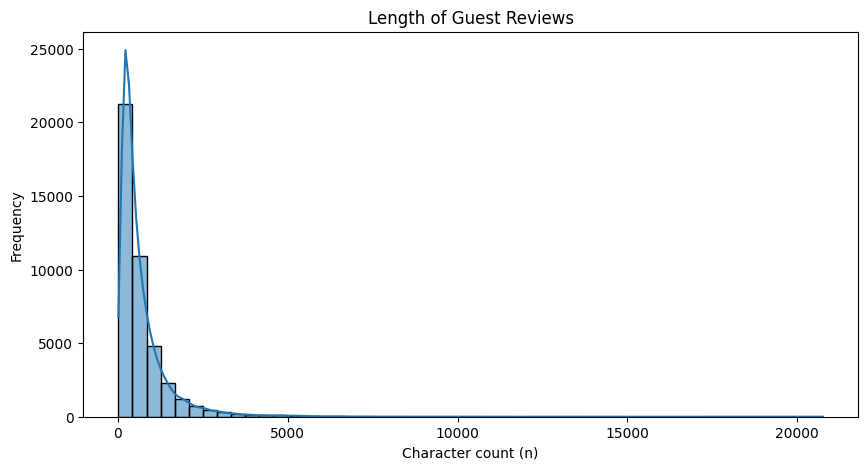

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic review length distribution
reviews["Review_Length"] = reviews["Review_Text"].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(reviews["Review_Length"], bins=50, kde=True)
plt.title("Length of Guest Reviews")
plt.xlabel("Character count (n)")
plt.ylabel("Frequency")
plt.show()

Majority are not that verbose, less than a 5000 count of total characters.

##### Checking for null values

In [6]:
# Checking nulls
reviews.isna().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
Review_Length        0
dtype: int64

No null values, good to proceed

## 3. Core Functions `summarize_review`, `analyze_sentiment`, `generate_response`

In [20]:
# Summary
def summarize_review(text):
    return summarizer(text, max_length = 50, min_length = 10, do_sample = False)[0]['summary_text']

# Sentiment Analysis
def analyze_sentiment(text):
    """Will return a result that reads like: {'label': 'POSITIVE', 'score' : 0.98}"""
    return sentiment_analyzer(text)[0]  # returns {'label': 'POSITIVE', 'score': 0.98}                            

# Preliminary response generation
def generate_response(summary, sentiment_label, branch = None, reviewer_location = None):
    """Rule based: will return a response based on whether the sentiment perceived was positive or negative. If unable, response will send a generic fallback 'thank you for your honest review.'"""
    sentiment_label = sentiment_label.lower()
    if "positive" in sentiment_label:
        return f"Thanks very much for your kind feedback. We're glad you enjoyed your magical day at {branch} and look forward to welcoming you back to the Happiest Place on Earth®! {summary}"

    elif "negative" in sentiment_label:
        return f"We're very sorry to hear your experience wasn't magical, especially since you came all the way from {reviewer_location}. We'll try to do better next time. {summary}"

    else:
        return f"Thank you for your honest review, have many more magical days! {summary}"

### Test on a single random review (quick check)

In [8]:
import random

# Selecting a random index from the dataset
random_index = random.randint(0, len(reviews) -1)
row = reviews.loc[random_index]

# Pull text, branch, and location
sample_text = row["Review_Text"]
sample_branch = reviews.loc[random_index, "Branch"]  # pulls from cleaned DataFrame
sample_location = reviews.loc[random_index, "Reviewer_Location"]

# Process review
summary = summarize_review(sample_text)
sentiment = analyze_sentiment(sample_text)
response = generate_response(summary, sentiment["label"], branch=sample_branch, reviewer_location=sample_location)

# Display the results
# Display results
print(f"Review #{random_index}\n")
print("Original Review:\n", sample_text)
print("\n Summary:\n", summary)
print("\n Sentiment:\n", sentiment)
print("\n Drafted Response:\n", response)

Review #21372

Original Review:
 When my husband wanted to spontaneously drive from San Francisco to Anaheim one Friday night so we could go to Disneyland for the first time, this weary Disney World lover was suspicious. We ended up absolutely loving the park, and spent all day there, soaking in every detail and visiting every attraction. Some of my friends who had visited both the Anaheim and Orlando Disney properties told me that Disney World was way better. After my visit, I have to disagree. I love Disneyland because of the added layers of history that augment the experience. All the pictures you see in the history books prove that Walt Disney loved Disneyland and, sadly, didn't live long enough to step foot in the finished Magic Kingdom at Disney World.My favorite attractions at this park include the Pirates of the Caribbean, the theming of New Orleans Square, and the Haunted Mansion Holiday overlay. The food is excellent and we had to eat a Monte Cristo sandwich to commemorate th

## 4. OpenAI-powered Response Generator

In [9]:
import openai

In [10]:
import os

In [11]:
from dotenv import load_dotenv

In [12]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

### Response Generation Function

In [13]:
from openai import OpenAI

client = OpenAI(api_key=api_key)

def openai_generate_response(review_text, reviewer_location="your location"):
    prompt = f"""
You are a Disneyland customer service representative.

A guest from {reviewer_location} wrote the following review:

\"\"\"{review_text}\"\"\"

Write a thoughtful, friendly, and professional response as if you personally read the review. Your response should:
- Acknowledge specific details from the review, especially if the review is negative.
- Reflect the tone of the guest's experience (positive, negative, or neutral)
- Be written in a sincere and human voice
- If the review is negative, offer some special offer or concession to apologize for the negative experience
- End with a **magical Disney-style farewell** (such as "Have a magical day!" or "We look forward to welcoming you back to the Happiest Place on Earth.")
- Sign off with a realistic name (e.g., "Best wishes, Chris – Disneyland Guest Services"). **Do not write '[Your Name]'. You MUST use an actual name.**

Keep it brief—no more than 5-7 sentences.
"""

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=300
    )

    return response.choices[0].message.content


### First test, randomly selected

In [14]:
# Select a random review
random_index = random.randint(0, len(reviews) - 1)
sample_text = reviews.loc[random_index, "Review_Text"]

# Call function to generate response based on sample review text
print("Original Review:\n", sample_text)
print("\n Drafted Response:\n", openai_generate_response(sample_text))

Original Review:
 Well, after 50 years of watching Disney from the Mickey Mouse Club to the latest live and animated movies I finally made it there and it was more than I imagined. I was like a kid in a toy store, my wife had to run to keep up with me! The sights the sounds the smells the rides the characters, everything I hoped my visit would be and even more. I took hundreds of photos, ate heaps of food and went on heaps of rides. Disneyland is for kids from 4 to 94! It is just an amazing place to visit. When it was time to leave I almost cried, but at my age the feet, back and legs said come on boy get me back to my hotel room I need to rest! Do it people, get to Disneyland, it is the place where dreams come true.

 Drafted Response:
 Dear valued guest,

Thank you so much for taking the time to share your wonderful experience at Disneyland with us! We are thrilled to hear that your visit exceeded your expectations and that you had a magical time exploring the park. It warms our hear

### Second Test: Hardcoded, Based on Negative sentiment

In [15]:
def analyze_sentiment(text):
    result = sentiment_analyzer(text)[0]  # {'label': 'POSITIVE', 'score': 0.93}
    return result["label"]

# Keep trying random reviews until you get a POSITIVE one
while True:
    random_index = random.randint(0, len(reviews) - 1)
    row = reviews.loc[random_index]
    
    sample_text = row["Review_Text"]
    summary = summarize_review(sample_text)
    sentiment_label = analyze_sentiment(summary)

    if sentiment_label == "NEGATIVE":
        break 

# Pull location and prepare input
review_with_sentiment = f"(Sentiment detected: {sentiment_label})\n\n{sample_text}"

#  Generate response
print(f"Sentiment: {sentiment_label}")
print("\nOriginal Review:\n",sample_text)
print("\nSummary:\n",summary)
print("\nDrafted Response:\n",
      openai_generate_response(review_with_sentiment))


Your max_length is set to 50, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Sentiment: NEGATIVE

Original Review:
 Just back from 3 days at Disneyland what should have been a pleasant experience but ended up with a very annoying 3 days .As several attractions were under renovation ( such as Peter Pan ) or due to technical problems even closed for several hours ( such as Ratatouille ) the crowd focused on those that were open with result of long cues and waiting times of up to 3 hours .Unacceptable experience and never again .

Summary:
 As several attractions were under renovation ( such as Peter Pan ) or due to technical problems even closed for several hours. The crowd focused on those that were open with result of long cues and waiting times of up to 3 hours.Unacceptable

Drafted Response:
 Dear valued guest,

Thank you for sharing your experience with us. We truly apologize for the inconvenience caused by the attractions under renovation and technical issues during your visit. Your feedback is valuable to us, and we will work diligently to ensure a more ma

### Third Test: Hardcoded, Based on Positive sentiment

In [16]:
def analyze_sentiment(text):
    result = sentiment_analyzer(text)[0]  # {'label': 'POSITIVE', 'score': 0.93}
    return result["label"]

# Keep trying random reviews until you get a POSITIVE one
while True:
    random_index = random.randint(0, len(reviews) - 1)
    row = reviews.loc[random_index]
    
    sample_text = row["Review_Text"]
    summary = summarize_review(sample_text)
    sentiment_label = analyze_sentiment(summary)

    if sentiment_label == "POSITIVE":
        break

# Pull location and prepare input
review_with_sentiment = f"(Sentiment detected: {sentiment_label})\n\n{sample_text}"

#  Generate response
print(f"Sentiment: {sentiment_label}")
print("\nOriginal Review:\n",sample_text)
print("\nSummary:\n",summary)
print("\nDrafted Response:\n",
      openai_generate_response(review_with_sentiment))


Your max_length is set to 50, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Sentiment: POSITIVE

Original Review:
 fantastic world story   bad and expensive services   super and safe montagnes russes   huge waiting lines  for the kids you have to go there at least once, for yourself.....it's up to your personality

Summary:
 Montagnes russes is one of the most popular tourist attractions in the world. It is located in the city of Montagnes, Russia.

Drafted Response:
 Thank you for sharing your feedback with us! We're happy to hear you enjoyed the fantastic world story and our super and safe montagnes russes. We apologize for any inconvenience you experienced with our services and long waiting lines. Your feedback is valuable to us, and we will work on improving these areas. We hope you'll give us another chance to create a magical experience for you and your family. Have a magical day!

Best wishes,
Sophia - Disneyland Guest Services


## 5. Full Pipeline Function: `analyze_and_respond`

In [17]:
from openai import OpenAI

client = OpenAI(api_key=api_key)

def analyze_and_respond(review_text, reviewer_location="your location"):
    """
    Full GenAI pipeline:
    - Summarizes the review
    - Analyzes sentiment
    - Adds sentiment & location context to the prompt
    - Generates a GPT response
    - Returns summary, sentiment, and full response
    """

    # Step 1: Summarize
    def summarize_review(text):
        return summarizer(text, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

    # Step 2: Sentiment Analysis
    def analyze_sentiment(text):
        result = sentiment_analyzer(text)[0]
        return result["label"]

    # Step 3: OpenAI Response
    def openai_generate_response(text_with_sentiment, reviewer_location="your location"):
        prompt = f"""
You are a Disneyland customer service representative.

A guest from {reviewer_location} wrote the following review:

\"\"\"{text_with_sentiment}\"\"\"

Write a thoughtful, friendly, and professional response as if you personally read the review. Your response should:
- Acknowledge specific details from the review, especially if the review is negative.
- Reflect the tone of the guest's experience (positive, negative, or neutral)
- Be written in a sincere and human voice
- If the review is negative, offer some special offer or concession to apologize for the negative experience
- End with a **magical Disney-style farewell** (such as "Have a magical day!" or "We look forward to welcoming you back to the Happiest Place on Earth.")
- Sign off with a realistic name (e.g., "Best wishes, Chris – Disneyland Guest Services"). **Do not write '[Your Name]'. You MUST use an actual name.**

Keep it brief—no more than 5–7 sentences.
"""

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=300
        )
        return response.choices[0].message.content

    try:
        summary = summarize_review(review_text)
        sentiment_label = analyze_sentiment(summary)
        review_with_sentiment = f"(Sentiment detected: {sentiment_label})\n\n{review_text}"
        response = openai_generate_response(review_with_sentiment, reviewer_location)

        return {
            "summary": summary,
            "sentiment": sentiment_label,
            "response": response
        }

    except Exception as e:
        return {
            "summary": None,
            "sentiment": None,
            "response": f"!! Failed to generate response: {e}"
        }

### Test case

In [18]:
row = reviews.sample(1).iloc[0]
review_text = row["Review_Text"]
reviewer_location = row.get("Reviewer_Location", "your location")

result = analyze_and_respond(review_text, reviewer_location)

print("Original Review:\n", review_text)
print("\nSummary:\n", result["summary"])
print("\nSentiment:", result["sentiment"])
print("\nFinal Response:\n", result["response"])


Original Review:
 It was a shame that so much of the park was closed off and we wasn't aware of how much was closed when we booked nearly a year ago else we might have changed when we went. But we still have a fabulous time. We didn't queue to meet any characters though as it was so busy the queues were huge! The dreams and parades were amazing! I absolutely loved every minute of those! 

Summary:
 It was a shame that so much of the park was closed off and we wasn't aware of how much was closed when we booked nearly a year ago. We didn't queue to meet any characters though as it was so busy the queues

Sentiment: NEGATIVE

Final Response:
 Dear valued guest from the United Kingdom,

Thank you for sharing your experience with us. We apologize for any disappointment caused by the closures during your visit. We strive to provide a magical experience for all our guests and are sorry that this was not fully met on this occasion. We're thrilled to hear that you still had a fabulous time and 


—

**Author**

Christopher Bacani, 2025